In [1]:
!python --version

Python 3.10.12


In [2]:
# !pip install flask-ngrok
!pip install qiskit-terra==0.20.2
!pip install qiskit-aer==0.10.4
!pip install qiskit-nature==0.4.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24059 sha256=80c44d8e54450942d7fde23f1d363b1ab8b1ea91f7a5047028426de648617443
  Stored in directory: /root/.cache/pip/wheels/2e/f2/2b/cb08b5fe129e4f69b7033061f256e5c551b0aa1160c2872aee
Successfully built python-constraint
   ━━━━━━

# Protein Folding

### Introduction

Le but de ce travail est de déterminer la conformation énergétique minimale d'une protéine. A partir d'une configuration aléatoire, la structure de la protéine est optimisée pour réduire l'énergie. Ceci peut être réalisé en codant le problème de repliement des protéines dans un opérateur qubit et en garantissant que toutes les contraintes physiques sont satisfaites.

Pour le problème d'encodage, nous utilisons :

Qubits de configuration : qubits utilisés pour décrire les configurations et la position relative des différentes billes

Qubits d'interaction : qubits qui codent les interactions entre les différents acides aminés

Pour notre cas, nous utilisons un réseau tétraédrique (réseau en forme de losange) où nous codons le mouvement à travers les qubits de configuration.

L'hamiltonien du système pour un ensemble de qubits $\mathbf{q}=\{\mathbf{q}_{cf}, \mathbf{q}_{in}\}$ is

$$H(\mathbf{q}) = H_{gc}(\mathbf{q}_{cf}) + H_{ch}(\mathbf{q}_{cf}) + H_{in}(\mathbf{q}_{cf}, \mathbf{q}_{in}) $$

Avec

- $H_{gc}$ est le terme de contrainte géométrique (gouvernant la croissance de la séquence primaire d'acides aminés sans bifurcations)

- $H_{ch}$ est la contrainte de chiralité (appliquant la bonne stéréochimie pour le système)

- $H_{in}$ sont les termes d’énergie d’interaction du système. Dans notre cas, nous considérons uniquement les interactions entre voisins les plus proches.

Nous avonq basés sur cette source [2] pour le modèle et l'encodage du problème .

In [ ]:
from qiskit_nature.problems.sampling.protein_folding.interactions.random_interaction import (
    RandomInteraction,
)
from qiskit_nature.problems.sampling.protein_folding.interactions.miyazawa_jernigan_interaction import (
    MiyazawaJerniganInteraction,
)
from qiskit_nature.problems.sampling.protein_folding.peptide.peptide import Peptide
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)

from qiskit_nature.problems.sampling.protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals, QuantumInstance

algorithm_globals.random_seed = 23

### Protein Main Chain




Pour ce cas particulier, nous démontrons la génération de l'opérateur qubit dans un neuropeptide dont la chaîne principale est constituée de 7 acides aminés[2].

In [ ]:
main_chain = "NQGAIWE"

### Side Chains

In [ ]:
side_chains = [""] * len(main_chain)

### Interaction between Aminoacids

Pour la description des contacts inter-résidus pour les protéines, nous utilisons des potentiels (statistiques) basés sur la connaissance dérivés par approximation quasi-chimique. Les potentiels utilisés ici sont introduits par Miyazawa, S. et Jernigan, R. L. in [5].

Au-delà de ce modèle, nous autorisons également des cartes de contacts aléatoires (interactions) qui fournissent une carte d'interaction aléatoire.

In [ ]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

### Physical Constraints

Pour garantir que toutes les contraintes physiques sont respectées, nous introduisons des fonctions de pénalité. Les différents termes de pénalité utilisés sont :

- Pénalité de Chiralité (penalty_chiral): Assurer la bonne chiralité des acides aminés.

- Pénalité de Retour (penalty_back): Empêcher la chaîne de se replier sur elle-même en choisissant deux fois de suite le même axe

- Pénalité de Chevauchement Local (penalty_1): Empêcher le chevauchement des perles (acides aminés) au niveau des contacts de voisins les plus proches.

In [ ]:
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

### Peptide Definition


Sur la base de la chaîne principale et des éventuelles chaînes latérales, nous définissons l'objet peptidique qui comprend toutes les informations structurelles du système modélisé.

In [ ]:
peptide = Peptide(main_chain, side_chains)

### Protein Folding Problem

on se basant sur le peptide défini, les interactions (carte de contact) et des termes de pénalité que nous avons définis pour notre modèle, nous définissons le problème de repliement des protéines qui renvoie les opérateurs qubit comme output.

In [ ]:
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

In [ ]:
print(qubit_op)

1614.0905 * IIIIIIIII
+ 487.5 * IIIIIIZII
- 192.5 * IIIIIIIZZ
+ 192.5 * IIIIIIZZZ
- 195.0 * IIIIZIZII
- 195.0 * IIIIIZIZI
- 195.0 * IIIIZZZZI
- 95.0 * IIZIZIIII
- 95.0 * IIIZIZIII
- 95.0 * IIZZZZIII
+ 295.0 * IIIIIIZZI
- 497.5 * IIIIZIIII
- 300.0 * IIIIZZIII
+ 195.0 * IIIIIIIIZ
+ 197.5 * IIIIIZIIZ
- 197.5 * IIIIZZIIZ
- 904.4535 * IZIIIIIII
- 295.0 * IZIIIIZII
- 197.5 * IZIIIIZZI
+ 302.5 * IZIIZIIII
+ 202.5 * IZIIZZIII
+ 100.0 * IZIIZIZII
+ 100.0 * IZIIIZIZI
+ 100.0 * IZIIZZZZI
- 200.0 * IZIIIIIIZ
+ 97.5 * IZIIIIIZZ
- 97.5 * IZIIIIZZZ
- 100.0 * IZIIIZIIZ
+ 100.0 * IZIIZZIIZ
+ 100.0 * IIIIIIIZI
- 100.0 * IIIIIZIII
+ 2.5 * IZIIIIIZI
- 2.5 * IZIIIZIII
+ 192.5 * IIZIIIIII
+ 95.0 * IIZZIIIII
+ 97.5 * IIZIIIZII
+ 97.5 * IIIZIIIZI
+ 97.5 * IIZZIIZZI
- 97.5 * IIIZIIIIZ
+ 97.5 * IIZZIIIIZ
+ 7.5 * IZZIIIIII
+ 5.0 * IZZZIIIII
+ 2.5 * IZZIIIZII
+ 2.5 * IZIZIIIZI
+ 2.5 * IZZZIIZZI
- 2.5 * IZZIZIIII
- 2.5 * IZIZIZIII
- 2.5 * IZZZZZIII
- 2.5 * IZIZIIIIZ
+ 2.5 * IZZZIIIIZ
+ 105.0 * IIIZIIIII
- 702.137 

**Using VQE with CVaR expectation value for the solution of the problem**





Le problème que nous abordons a maintenant implémenté toutes les contraintes physiques et possède un hamiltonien diagonal. Pour le cas particulier nous ciblons la seule chaîne de bits qui nous donne le minimum d'énergie (correspondant à la structure repliée de la protéine). Nous suivons la même approche que dans la Réf. [2] mais ici nous utilisons COBYLA pour la partie optimisation classique.

In [ ]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit import execute, Aer

# set classical optimizer
optimizer = COBYLA(maxiter=100)

# set variational ansatz
ansatz = RealAmplitudes(reps=1)

# set the backend
backend_name = "aer_simulator"
backend = QuantumInstance(
    Aer.get_backend(backend_name),
    shots=8192,
    seed_transpiler=algorithm_globals.random_seed,
    seed_simulator=algorithm_globals.random_seed,
)

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# initialize CVaR_alpha objective with alpha = 0.1
cvar_exp = CVaRExpectation(0.1, PauliExpectation())

# initialize VQE using CVaR
vqe = VQE(
    expectation=cvar_exp,
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
    callback=store_intermediate_result,
)

raw_result = vqe.compute_minimum_eigenvalue(qubit_op)
print(raw_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': {   '000000100': 0.02209708691207961,
                      '000000101': 0.0427908248050911,
                      '000000110': 0.038273277230987154,
                      '000001110': 0.011048543456039806,
                      '000010101': 0.011048543456039806,
                      '000011010': 0.011048543456039806,
                      '000100101': 0.019136638615493577,
                      '000100110': 0.02209708691207961,
                      '000101001': 0.011048543456039806,
                      '000101010': 0.011048543456039806,
                      '000111001': 0.011048543456039806,
                      '000111100': 0.011048543456039806,
                      '000111101': 0.011048543456039806,
                      '000111110': 0.011048543456039806,
                      '001000000': 0.011048543456039806,
                      '001000001': 0.011048543456039806,
                      

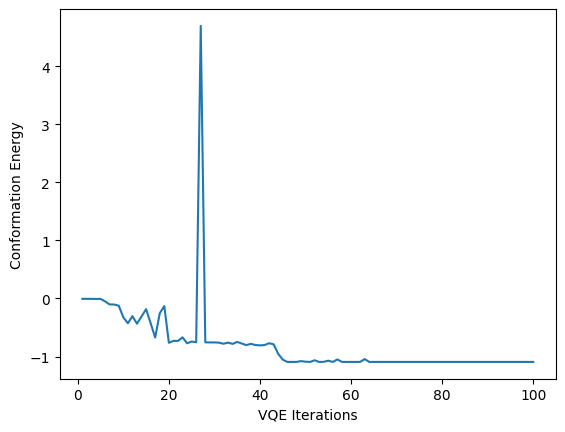

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

# fig.add_axes([0.44, 0.51, 0.44, 0.32])

# plt.plot(counts[40:], values[40:])
# plt.ylabel("Conformation Energy")
# plt.xlabel("VQE Iterations")
plt.show()

**Visualisation**

Afin de réduire les coûts de calcul, nous avons réduit l'opérateur qubit du problème au nombre minimum de qubits nécessaire pour représenter la forme de la protéine.
* The shape of the protein has been encoded by a sequence of turns , $\{0,1,2,3\}$. Each turn represents a different direction in the lattice.
* For a main bead of $N_{aminoacids}$ in a lattice, we need $N_{aminoacids}-1$ turns in order to represent its shape.
* Since the length of the secondary chains is always limited to $1$ we only need one turn to describe the shape of the chain.

Le nombre totale de qubits dont nous avons besoin pour représenter la forme de la protéine sera $2(N_{aminoacids}-3)$ s'il y a une chaîne secondaire qui sort de la deuxième perle ou $2(N_{aminoacids}-3) - 1$, Sinon. Tous les autres qubits resteront inutilisés pendant le processus d'optimisation :

In [ ]:
result = protein_folding_problem.interpret(raw_result=raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())

The bitstring representing the shape of the protein during optimization is:  011000110
The expanded expression is: 0______1_____________________________________________________________________________________________________________________________100011_0____


Maintenant que nous savons quels qubits codent quelles informations, nous pouvons décoder la chaîne de bits en tours explicites qui forment la forme de la protéine.

In [ ]:
print(f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}")
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 1, 3, 0, 1]
and the side turn sequences are: [None, None, None, None, None, None, None]


A partir de cette séquence de tours on peut obtenir les coordonnées cartésiennes de chacun des acides aminés de la protéine.

In [ ]:
print(result.protein_shape_file_gen.get_xyz_data())

[['N' '0.0' '0.0' '0.0']
 ['Q' '0.5773502691896258' '0.5773502691896258' '-0.5773502691896258']
 ['G' '1.1547005383792517' '0.0' '-1.1547005383792517']
 ['A' '1.7320508075688776' '0.5773502691896258' '-1.7320508075688776']
 ['I' '1.154700538379252' '1.1547005383792517' '-2.3094010767585034']
 ['W' '0.5773502691896261' '1.7320508075688776' '-1.7320508075688776']
 ['E' '2.220446049250313e-16' '1.154700538379252' '-1.154700538379252']]


Finalement, nous faisons la visualisation de la strucure du protèine résultant.

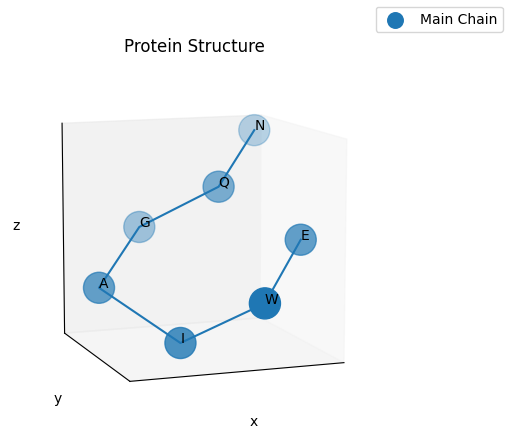

In [ ]:
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

In [ ]:
!pip install plotly

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Vos données avec acides aminés et coordonnées XYZ
data = result.protein_shape_file_gen.get_xyz_data()

# Extraire les informations des acides aminés et des coordonnées
amino_acids = data[:, 0]
coordinates = data[:, 1:].astype(float)

# Créer la figure plotly
fig = go.Figure()

# Ajouter les points des acides aminés
fig.add_trace(go.Scatter3d(
    x=coordinates[:, 0],
    y=coordinates[:, 1],
    z=coordinates[:, 2],
    mode='markers+text',
    marker=dict(size=5),
    text=[f'{amino_acids[i]}' for i in range(len(amino_acids))],
    textposition='top center'
))

# Ajouter les lignes reliant les points pour visualiser la structure
fig.add_trace(go.Scatter3d(
    x=coordinates[:, 0],
    y=coordinates[:, 1],
    z=coordinates[:, 2],
    mode='lines',
    line=dict(width=2)
))

# Ajouter des étiquettes d'axes
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="Visualisation 3D de la Protéine"
)

# Afficher la figure interactive
fig.show()


And here is an example with side chains.

In [ ]:
# peptide = Peptide("APRLR", ["", "", "F", "Y", ""])
# protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
# qubit_op = protein_folding_problem.qubit_op()
# raw_result = vqe.compute_minimum_eigenvalue(qubit_op)
# result_2 = protein_folding_problem.interpret(raw_result=raw_result)

In [ ]:
# fig = result_2.get_figure(title="Protein Structure", ticks=False, grid=True)
# fig.get_axes()[0].view_init(10, 60)



<font size='2'>[2] A.Robert, P.Barkoutsos, S.Woerner and I.Tavernelli, Resource-efficient quantum algorithm for protein folding, NPJ Quantum Information, 2021, https://doi.org/10.1038/s41534-021-00368-4 </font>

<font size="2">[3] IUPAC–IUB Commission on Biochemical Nomenclature (1972). "A one-letter notation for aminoacid sequences". Pure and Applied Chemistry. 31 (4): 641–645. doi:10.1351/pac197231040639. PMID 5080161.</font> <br>
